In [1]:
%matplotlib inline
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.optimizers import Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

Using TensorFlow backend.


In [2]:
from skimage import io
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt 
image_coll = ['A', 'B', 'C','D','E','F','G','H','I','J'] 
X_train = []
for collections in image_coll:
    print('loading images: ' + collections)
    coll = io.ImageCollection('../data/notMNIST_small/' + collections + '/*.png')
    for img in coll:
        X_train.append(resize(img,(28,28,1)))
# convet to numpy array
X_train = np.array(X_train)
print(X_train.shape)

loading images: A
loading images: B
loading images: C
loading images: D
loading images: E
loading images: F
loading images: G
loading images: H
loading images: I
loading images: J
(18724, 28, 28, 1)


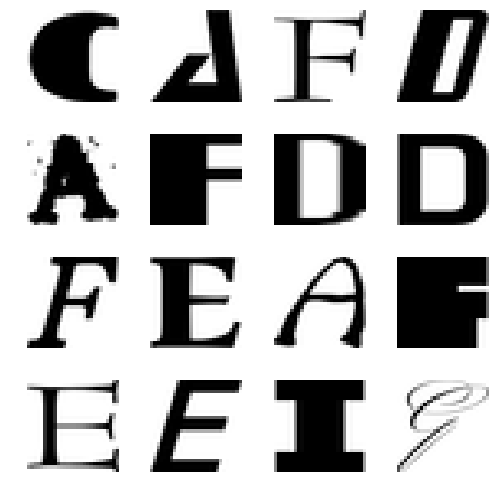

In [22]:
index = np.random.choice(X_train.shape[0],16)
samples = X_train[index,:,:,:]
plt.figure(figsize=(7,7))
for i in range(samples.shape[0]):
    plt.subplot(4,4,i+1)
    img = samples[i,:,:,0]
    plt.imshow(img,interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
img_rows, img_cols = 28, 28
X_train = (X_train.astype('float32') -0.5)/0.5

print(np.min(X_train), np.max(X_train))
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

-1.0 1.0
X_train shape: (18724, 28, 28, 1)
18724 train samples


In [6]:
shp = X_train.shape[1:]
inidim = 100
print(shp)
# Optim
#adam = Adam(lr=0.0002, beta_1=0.5)
dropout_rate = 0.3
opt = Adam(lr=2e-4,beta_1=0.5)
dopt = Adam(lr=2e-4,beta_1=0.5)


# Build Generative model ...
g_input = Input(shape=[inidim])
H = Dense(7*7*128, kernel_initializer='glorot_normal')(g_input)
H = LeakyReLU(0.2)(H)
H = Reshape( [7, 7, 128] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
H = LeakyReLU(0.2)(H)
H = UpSampling2D(size=(2, 2))(H)
H = Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform')(H)
g_V = Activation('tanh')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

# Build Discriminative model ...

d_input = Input(shape=shp)
H = Conv2D(64, (5, 5), strides=(2, 2), padding= 'same')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Conv2D(128, (5, 5), strides=(2, 2), padding = 'same')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
#H = Conv2D(256, (5, 5), strides=(2, 2), padding = 'same')(H)
#H = LeakyReLU(0.2)(H)
#H = Dropout(dropout_rate)(H)
#H = Conv2D(512, (5, 5), padding = 'same')(H)
#H = LeakyReLU(0.2)(H)
#H = Dropout(dropout_rate)(H)
H = Flatten()(H)
#H = Dense(128)(H)
#H = LeakyReLU(0.2)(H)
#H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='sigmoid')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='binary_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
discriminator.trainable = False
# Build stacked DCGAN model
gan_input = Input(shape=[inidim])
x = generator(gan_input)
gan_V = discriminator(x)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='binary_crossentropy', optimizer=opt)
GAN.summary()

(28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0        

In [7]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

In [8]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(7,7) ):
    noise = np.random.normal(0,1,size=[n_ex,inidim])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img,interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
ntrain = 5000
trainidx = np.random.choice(X_train.shape[0], ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.normal(0,1,size=[XT.shape[0],inidim])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

discriminator.trainable = True
discriminator.fit(X,y, epochs=1, batch_size=32)
y_hat = discriminator.predict(X)


Epoch 1/1
10000/10000 [==============================] - 32s - loss: 0.0948      

In [12]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

Accuracy: 100.00 pct (10000 of 10000) right


In [13]:
# set up loss storage vector
losses = {"d":[], "g":[]}

In [14]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.choice(X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        discriminator.trainable = True
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        discriminator.trainable = False
        for i in range(1):
            noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,inidim])
            y2 = np.zeros([BATCH_SIZE,2])
            y2[:,1] = 1
            g_loss = GAN.train_on_batch(noise_tr, y2 )
        
        
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==0:
            plot_loss(losses)
            plot_gen()
        

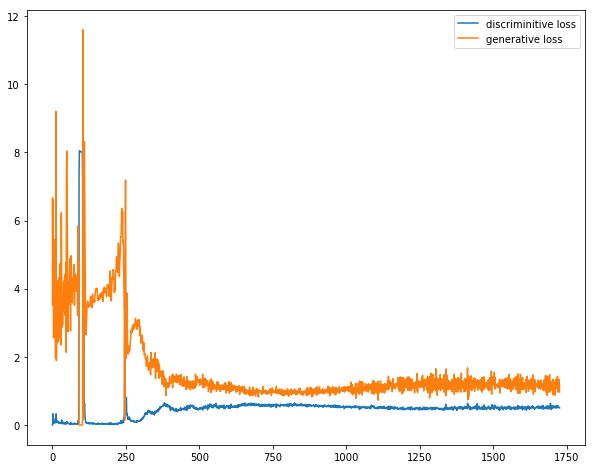

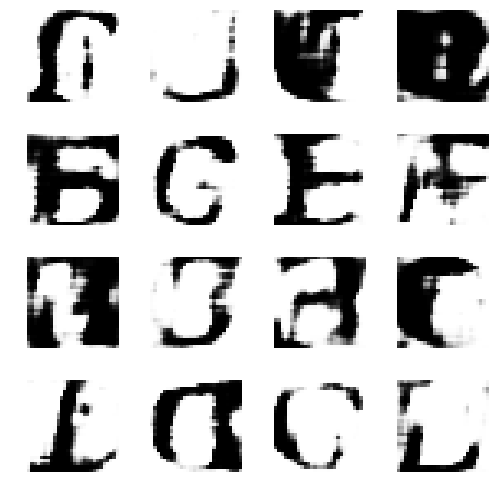

100%|██████████| 250/250 [14:46<00:00,  3.25s/it]


In [28]:

train_for_n(nb_epoch=250, plt_frq=25,BATCH_SIZE=128)

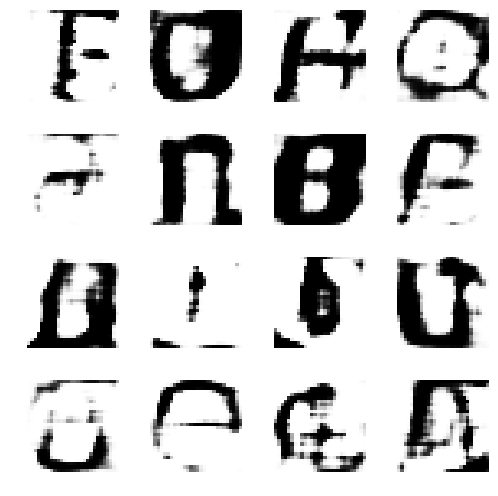

In [29]:
plot_gen()

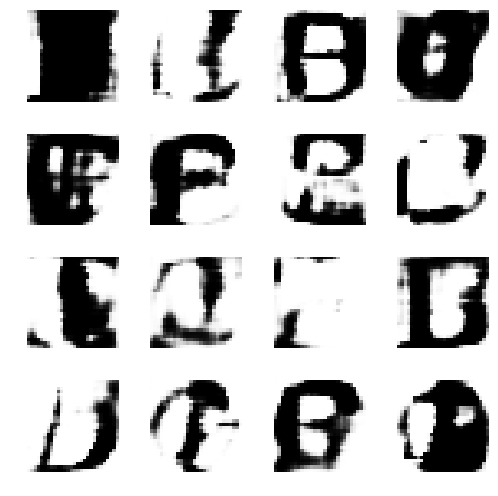

In [30]:
plot_gen()

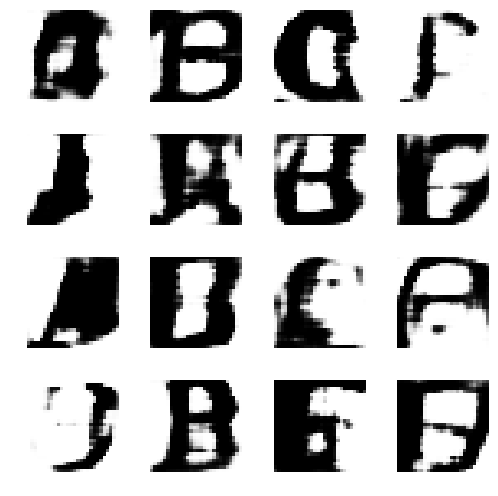

In [31]:
plot_gen()